<center><span style="font-size:36px;">  🏈Expected Tackle Success Rate (ETSR) and Tackle Index🏈</span> </center>

***

### <font color='289C4E'  align>Table of contents<font><a class='anchor' id='top'></a>
- [Introduction](#1)
- [Data Summary](#2)
- [The ETSR Model](#3)
- [Applying ETSR to Player Data](#4)
- [Testing the ETSR and Tackle Index](#5)
- [How is this useful and innovative?](#6)


***

# Introduction <a class="anchor"  id="1"></a>

## Tackling Statistics
 Currently, the main metrics that are used to evaluate players and their ability to tackle are composed of raw counts and percentages. We can look at how many solo tackles, assists, and sacks that a player has and we can look at the percentage of tackle attempts they made that were successful. However, we believe that there is a bigger question that needs to be answered...*what makes a good tackle?*

#### By "good", we mean, what differentiates a successful tackle attempt from a missed tackle. 

### Project Goal:
To analyze historical tracking data and extract meaningful features to predict when a tackle attempt will be successful. We will then apply the model to players and determine their "Expected Tackle Success Rate (ETSR)", which we define as "the overall probability that a player's tackle attempt will be successful"

We also introduce the "Tackle Index", which allows us to rank players based on their current track record related to tackling in addition to their ETSR. This accounts for consistent performance and number of games played.

***

# Data Summary <a class="anchor"  id="2"></a>
The data used for this analysis includes 2022 player tracking data, game data, play data, tackle data, and player statistics. To start, we combined this data to create a comprehensive table that could be used to look at every tackle attempt in the tracking data, tied to the ball carrier at the time and the tackler.


We engineered additional features to supplement the data. Examples include:
- Standardized directional and positional data (to account for plays going in different directions)
- Force (Mass*Acceleration)
- Momentum (Mass * speed)
- Relative velocity: We looked at the speed of the ball carrier compared to the tackler
- Relative position: Distance between the ball carrier and tackler throughout the play
- Coefficient of Restitution COR= $\frac{(v_{2f} - v_{1f})}{(v_{2i} - v_{1i})}$ 


In order to look at what distinguishes a successful tackle from a missed tackle, we specifically excluded assists for the current model. Therefore, we looked at **7895** successful tackles and **2001** missed tackles. 

###  $\frac {7895}{9896}$ = 80%

#  The ETSR Model <a class="anchor"  id="3"></a>

Our model of Expected Tackle Success Rate (ETSR) blends the predictions from three classification models: **LGBMClassifier** , **XGBoost Classifier**, and **RandomForestClassifier**.
The two models take the following features into account when assessing whether a tackle attempt will be successful:

- The orientation of the tackler
- The direction of the tackler
- The tackler's acceleration
- The ball carrier's speed
- The distance traveled by the ball carrier
- The speed of the tackler before the attempt
- The speed of the ball carrier before the attempt

By blending combinations of these features (i.e. the average speed of the ball carrier and the maximum speed of the tackler before the tackle attempt), the ETSR model predicts the tackle attempts success with 
### 85.6% Accuracy
The other metrics we used to assess the model's performance include F1 score, precision, recall, and Cohen's Kappa. (See appendix with resources on classification model metrics).


#  Applying ETSR to Player Data <a class="anchor"  id="4"></a>

We propose that coaches utilize the ETSR model for their players that need to be tracked for tackling ability. The ETSR score ranges from 0 to 1, with 1 being the highest expected success rate. However, this metric can be biased towards players with little data because if they only had one tackle attempt and it was successful, their score will be very close to 1. Therefore, we developed a **Tackle Index**  which factors in how many attempts a player actually made (proxy for their snap count).

## Tackle Index Calculation
The tackle index is relative to other players. It can be negative, zero , or positive depending on the previous tackles and missed tackles that the player has made. On the other hand, RTA always ranges from 0 to 1.

#### ${ETSR \times (Tackle Count + (.5 \times Assist Count)} -{[{(1-ETSR) \times Missed Tackle Count}+1]} $


In [1]:

from IPython.display import Image
import warnings
#!pip install eli5
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None)
#Image("/kaggle/input/shap-plots/LGBMshap.png")


In [2]:

df_games=pd.read_csv('games.csv')
df_players=pd.read_csv('players.csv')
df_plays=pd.read_csv('plays.csv')
df_tackles=pd.read_csv('tackles.csv')
files=[]
for i in range(1,10):
    file='tracking_week_'+str(i)+'.csv'
    files.append(pd.read_csv(file))
    df_tracking=pd.concat(files) 



In [3]:
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 180:
        return deg - 180


In [4]:
df_tracking["o_standard"]=np.where(df_tracking["playDirection"] == "left", df_tracking["o"].apply(reverse_deg), df_tracking["o"])
        
df_tracking["dir_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["dir"].apply(reverse_deg), df_tracking["dir"])
        
df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])
        
df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
    

In [5]:
def create_gameplayid(df):
    df['gameplayid']=df['gameId'].astype(str)+df['playId'].astype(str)
    return df

def create_index(df):
    df['index']=df['nflId'].astype(str)+df['gameplayid']
    return df
df_tracking=create_index(create_gameplayid(df_tracking))

df_plays=create_gameplayid(df_plays)
df_tackles=create_index(create_gameplayid(df_tackles))



In [6]:
#df_tackles[df_tackles['gameplayid']=='20220911083366']

In [7]:
#df_tracking[(df_tracking['gameplayid']=='20220911083366') & (df_tracking['displayName']=='Kristian Fulton')]

In [8]:
print('Distinct plays in tracking data: ', df_tracking['gameplayid'].nunique())
print('Distinct plays in play data: ', df_plays['gameplayid'].nunique())
print('Distinct plays in tackles data: ', df_tackles['gameplayid'].nunique())

Distinct plays in tracking data:  12486
Distinct plays in play data:  12486
Distinct plays in tackles data:  12025


In [9]:
df_tackles.head()

gameId  playId  nflId  tackle  assist  forcedFumble  pff_missedTackle  \
0  2022090800     101  42816       1       0             0                 0   
1  2022090800     393  46232       1       0             0                 0   
2  2022090800     486  40166       1       0             0                 0   
3  2022090800     646  47939       1       0             0                 0   
4  2022090800     818  40107       1       0             0                 0   

      gameplayid               index  
0  2022090800101  428162022090800101  
1  2022090800393  462322022090800393  
2  2022090800486  401662022090800486  
3  2022090800646  479392022090800646  
4  2022090800818  401072022090800818

In [10]:
def merge_clean_data(df_tracking, df_plays, df_tackles):
    df_tracking_plays_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=['gameplayid', 'gameId', 'playId'], right_on=['gameplayid', 'gameId', 'playId'], how='inner'), df_tackles, left_on=['gameplayid', 'gameId', 'playId', 'nflId'], right_on=['gameplayid', 'gameId', 'playId', 'nflId'], how='inner' )

  
    df_tackles_final=pd.merge(df_tracking_plays_final, df_tackles, left_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], right_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle','assist', 'pff_missedTackle'], how='left', suffixes=['_1', '_2'])
    df_tackles_final=df_tackles_final[((df_tackles_final['gameplayid'].isna()==False))]
    df_tackles_final['tackle_event']=np.where((df_tackles_final['tackle']==1) & (df_tackles_final['event']=='tackle'), 1,0)
    df_tackles_final['missed_tackle']=np.where((df_tackles_final['tackle']==0) & (df_tackles_final['pff_missedTackle']==1), 1, 0)
    df_tackles_final['index']=df_tackles_final['nflId'].astype(str)+df_tackles_final['gameplayid'].astype(str)+df_tackles_final['frameId'].astype(str)
    return df_tackles_final
df_tackles_final=merge_clean_data(df_tracking, df_plays, df_tackles)

In [11]:

print('Distinct plays in  final data: ', df_tackles_final['gameplayid'].nunique())
print('Distinct frames in  final data: ', df_tackles_final['index'].nunique())

Distinct plays in  final data:  12022
Distinct frames in  final data:  804123


In [12]:
def ballcarrier_df(df_players):
    df_ballcarrier_players=df_players.copy()
    df_ballcarrier_players.columns=['nflId_ballcarrier', 'ballCarrierHeight', 'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege', 'ballcarrierPosition', 'ballCarrierDisplayName']
    
    df_tracking_ballcarrier=df_tracking[['gameplayid', 'frameId','nflId', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard']]
    df_ballcarrier=pd.merge(df_tracking_ballcarrier, df_ballcarrier_players, left_on='nflId', right_on='nflId_ballcarrier')
    df_ballcarrier=df_ballcarrier[['gameplayid', 'frameId',  'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard', 'nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']]
    df_ballcarrier.columns=['gameplayid', 'frameId',  'x_ballcarrier', 'y_ballcarrier', 's_ballcarrier',
                        'a_ballcarrier', 'dis_ballcarrier', 'o_ballcarrier',
       'dir_ball_carrier', 'event_ballcarrier', 'o_standard_ballcarrier', 'dir_standard_ballcarrier', 'x_standard_ballcarrier',
       'y_standard_ballcarrier','nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']
    return df_ballcarrier
    
df_ballcarrier=ballcarrier_df(df_players)


In [13]:
def full_merge(df_tackles_final):
    df_players_tackler=df_players.copy()
    df_players_tackler.columns=['nflId_tackler', 'tacklerHeight', 'tacklerWeight', 'tacklerDOB', 'tacklerCollege', 'tacklerPosition', 'tacklerDisplayName']
    df_tackles_final=pd.merge(df_tackles_final, df_players_tackler, left_on='nflId', right_on='nflId_tackler')
    df_full=pd.merge(df_tackles_final, df_ballcarrier, left_on=['gameplayid','ballCarrierDisplayName','frameId'], right_on=['gameplayid', 'ballCarrierDisplayName','frameId'])
    df_full.rename(columns={ 'x':'x_tackler','y': 'y_tackler', 's':'s_tackler', 'a':'a_tackler', 'dis':'dis_tackler',
       'o':'o_tackler', 'dir':'dir_tackler', 'event':'event_tackler', 'o_standard':'o_standard_tackler',
       'dir_standard':'dir_standard_tackler', 'x_standard':'x_standard_tackler', 'y_standard':'y_standard_tackler'}, inplace=True)
    return df_full
df_full=full_merge(df_tackles_final)


- In physics, there are two types of collisions: elastic and inelastic. An elastic collision results in objects moving apart at the same rate at which they collided. On the other hand, an inelastic collision results in objects staying stuck together. According to [The University of Arkansas ](https://phys.libretexts.org/Courses/Merrimack_College/Conservation_Laws_Newton's_Laws_and_Kinematics_version_2.0/08%3A_C8_Conservation_of_Energy-_Kinetic_and_Gravitational/8.05%3A_Relative_Velocity_and_the_Coefficient_of_Restitution) you can quantify how elastic a collision is with the coefficient of restitution (COR). Typically football tackles are classified as inelastic collisions, but we'd like to use the COR to quantify how inelastic a tackle is.



In [14]:
def create_force_features(df_full):
    df_full['force_ballcarrier']=df_full['ballCarrierWeight']*df_full['a_ballcarrier']
    df_full['force_tackler']=df_full['tacklerWeight']*df_full['a_tackler']
    df_full['momentum_ballcarrier']=df_full['ballCarrierWeight']*df_full['s_ballcarrier']
    df_full['momentum_tackler']=df_full['tacklerWeight']*df_full['s_tackler']
    #calculate distance between player tackling and player being tackled
    df_full['dis_ballcarrier_tackler']=np.sqrt(((df_full['x_standard_ballcarrier'] -df_full['x_standard_tackler'])**2)+((df_full['y_standard_ballcarrier'] -df_full['y_standard_tackler'])**2))
    return df_full
df_full=create_force_features(df_full)


In [15]:
import time

def minutes_to_seconds(minutes):
  return minutes * 60

def seconds_to_minutes(seconds):
  return seconds // 60
def convert_minutes_to_seconds(hours_minutes_and_seconds):
  hours, minutes, seconds = hours_minutes_and_seconds.split(':')
  return minutes_to_seconds(int(minutes)) + seconds_to_minutes(float(seconds))




In [16]:
import datetime 
from datetime import datetime

df_full['time']=df_full['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f' ))
df_full['time_adj']=df_full['time'].apply(lambda x: x.time())
df_full['time_seconds']=df_full['time_adj'].apply(lambda x: convert_minutes_to_seconds(str(x)))


In [17]:

df_full['time_elapsed']=df_full.groupby(['gameplayid', 'frameId'])['time_seconds'].diff()


In [18]:
df_full.sort_values(by=['gameplayid', 'frameId'], inplace=True)


In [19]:

df_full['relative_direction']=df_full['dir_standard_tackler']-df_full['dir_standard_ballcarrier']
df_full['relative_o']=df_full['o_standard_tackler']-df_full['o_standard_ballcarrier']
df_full['playNullifiedByPenalty'].replace({'Y':1, 'N':0}, inplace=True)

In [20]:
df_groupplay=df_full.groupby(by=['gameplayid', 'displayName'])['dis_ballcarrier_tackler'].min().reset_index()
df_groupplay['tackleframe']=1
df_full=pd.merge(df_groupplay, df_full, left_on=['gameplayid', 'displayName', 'dis_ballcarrier_tackler'], right_on=['gameplayid','displayName', 'dis_ballcarrier_tackler'], how='right')
df_full['tackle_frame_final']=np.where((df_full['tackleframe']==1), 1, 0)
df_full['prior_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(1)
df_full['next_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(-1)
df_full['prior_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(1)
df_full['next_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(-1)


In [21]:
def group_by_play(df_full):
    df_full_grouped=df_full.groupby(by=['gameplayid',  'displayName', 'nflId_tackler', 'nflId_ballcarrier']).agg({'tackle_event':'max', 'assist':'max', 'missed_tackle':'max','playNullifiedByPenalty':'max', 'relative_o':'mean', 'relative_direction':'mean', 'time':['min', 'max'], 'time_seconds':['min', 'max'],'offenseFormation':pd.Series.mode,'tacklerPosition': pd.Series.mode, 'ballcarrierPosition':pd.Series.mode,'offenseFormation':'first',  'x_tackler':['min', 'max','mean'], 'y_tackler':['min', 'max','mean'],
                                  's_tackler':['first', 'last','min', 'max','mean'],'prior_speed_tackler':'max', 'next_speed_tackler':'max', 'prior_speed_ballcarrier':'max', 'next_speed_ballcarrier':'max', 'a_tackler':['min', 'max','mean'], 'dis_tackler':['min', 'max','mean'],
                                   'o_standard_tackler':['min', 'max','mean'],
                                  'dir_standard_tackler':['min', 'max','mean'], 'x_standard_tackler':['min', 'max','mean'], 'y_standard_tackler':['min', 'max','mean'],
                                  'quarter':['min', 'max','mean'], 'down':['min', 'max','mean'], 'yardsToGo':['min', 'max','mean'],
                                  'gameClock':['min', 'max'], 'preSnapHomeScore':['min', 'max','mean'], 'preSnapVisitorScore':['min', 'max','mean'],
                                   'absoluteYardlineNumber':['min', 'max','mean'], 'defendersInTheBox': ['min', 'max','mean'],
                                  'expectedPoints':['min', 'max','mean'],  'tacklerWeight': 'mean',
                                   's_ballcarrier':['first', 'last','min', 'max','mean'],
                                  'a_ballcarrier':['min', 'max','mean'], 'dis_ballcarrier': ['min', 'max','mean'],
                                  'o_standard_ballcarrier':['min', 'max','mean'],'dir_standard_ballcarrier':['min', 'max','mean'],
                                  'x_standard_ballcarrier':['min', 'max','mean'], 'y_standard_ballcarrier':['min', 'max','mean'], 'ballCarrierWeight':'mean', 'force_ballcarrier':['min', 'max','mean'],
                                  'force_tackler':['min', 'max','mean']}).reset_index()
    df_full_grouped.columns =df_full_grouped.columns.map('|'.join).str.strip('|')
    return df_full_grouped
df_full_grouped=group_by_play(df_full)



In [22]:
df_full_grouped=df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]

## Summary Statistics

In [23]:
print('Total plays: ', df_full_grouped['gameplayid'].nunique())
print('Total plays not nullified by penalty: ', df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]['gameplayid'].nunique())
print('Total row count: ', len(df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]))
print('Total missed tackles: ', len(df_full_grouped[((df_full_grouped['missed_tackle|max']==1))]['gameplayid']))
print('Total assists: ', len(df_full_grouped[((df_full_grouped['assist|max']==1))]['gameplayid']))
print('Total tackles: ', len(df_full_grouped[((df_full_grouped['tackle_event|max']==1))]['gameplayid']))

Total plays:  11700
Total plays not nullified by penalty:  11700
Total row count:  16988
Total missed tackles:  2001
Total assists:  5396
Total tackles:  7895


In [24]:
df_speed_subset=df_full[df_full['tackle_frame_final']==1][['gameplayid', 'displayName', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier']]

In [25]:
df_speed_subset.fillna(0, inplace=True)

In [26]:
df_playdescription = df_plays[['gameId', 'playId', 'playDescription', 'gameClock']].sort_values(by=['gameId',  'gameClock']).set_index('gameId')
df_gamedescription=df_playdescription.groupby(['gameId'])[['playDescription']].transform(lambda x: ','.join(x)).reset_index().drop_duplicates()
df_gamedescription.rename(columns={'playDescription':'gameDescription'}, inplace=True)

In [27]:
def create_position_variables(df_full_grouped):

    ballcarrier_position=pd.get_dummies(df_full_grouped[['gameplayid',  'displayName', 'ballcarrierPosition|mode']], columns=['ballcarrierPosition|mode'],drop_first=True).reset_index(drop=True)
    ballcarrier_position.columns=['gameplayid', 'displayName', 'QB_ballcarrier', 'RB_ballcarrier', 'TE_ballcarrier', 'WR_ballcarrier']
    tackler_position=pd.get_dummies(df_full_grouped[['gameplayid','displayName', 'tacklerPosition|mode']], columns=['tacklerPosition|mode'],drop_first=True).reset_index(drop=True)
    tackler_position.columns=['gameplayid', 'displayName', 'tacklerPosition|mode_DB', 'tacklerPosition|mode_DE',
       'tacklerPosition|mode_DT', 'tacklerPosition|mode_FS',
       'tacklerPosition|mode_ILB', 'tacklerPosition|mode_MLB',
       'tacklerPosition|mode_NT', 'tacklerPosition|mode_OLB',
       'tacklerPosition|mode_SS']
    offense_formation=pd.get_dummies(df_full_grouped[['gameplayid', 'displayName','offenseFormation|first']], columns=['offenseFormation|first'], drop_first=True).reset_index(drop=True)
    df_merge=pd.merge(df_full_grouped,ballcarrier_position, on=['gameplayid', 'displayName'] )
    df_merge=pd.merge(df_merge,tackler_position, on=['gameplayid', 'displayName'])
    df_merge=pd.merge(df_merge, offense_formation, on=['gameplayid', 'displayName'])
    
    
    return df_merge
df_full_grouped=create_position_variables(df_full_grouped)

In [28]:
def create_diff_range(df_final):
    df_final['difference_speed']=df_final['s_tackler|max']-df_final['s_ballcarrier|max']
    df_final['difference_a']=df_final['a_tackler|max']-df_final['a_ballcarrier|max']
    df_final['difference_orientation']=df_final['o_standard_tackler|max']-df_final['o_standard_ballcarrier|max']
    df_final['tackler_x_range']=df_final['x_standard_tackler|max']-df_final['x_standard_tackler|min']
    df_final['tackler_y_range']=df_final['y_standard_tackler|max']-df_final['y_standard_tackler|min']
    df_final['tackler_s_range']=df_final['s_tackler|max']-df_final['s_tackler|min']
    df_final['tackler_a_range']=df_final['a_tackler|max']-df_final['a_tackler|min']
    df_final['o_range_tackler']=df_final['o_standard_tackler|max']-df_final['o_standard_tackler|min']
    df_final['dir_range_tackler']=df_final['dir_standard_tackler|max']-df_final['dir_standard_tackler|min']
    df_final['ballcarrier_x_range']=df_final['x_standard_ballcarrier|max']-df_final['x_standard_ballcarrier|min']
    df_final['ballcarrier_y_range']=df_final['y_standard_ballcarrier|max']-df_final['y_standard_ballcarrier|min']
    df_final['ballcarrier_s_range']=df_final['s_ballcarrier|max']-df_final['s_ballcarrier|min']
    df_final['ballcarrier_a_range']=df_final['a_ballcarrier|max']-df_final['a_ballcarrier|min']
    df_final['o_range_ballcarrier']=df_final['o_standard_ballcarrier|max']-df_final['o_standard_ballcarrier|min']
    df_final['dir_range_ballcarrier']=df_final['dir_standard_ballcarrier|max']-df_final['dir_standard_ballcarrier|min']
    df_final['next_speed_diff']= (df_final['next_speed_tackler|max']-df_final['next_speed_ballcarrier|max'])
    df_final['prior_speed_diff']=(df_final['prior_speed_tackler|max']-df_final['prior_speed_ballcarrier|max'])
    df_final['COR']=np.where(df_final['tackle_event|max']==1, (df_final['next_speed_diff']).astype(float)/(df_final['prior_speed_diff']+1).astype(float),0 )
    df_final['COR'].replace([float('inf'), float('-inf')], 0, inplace=True)

    return df_final
df_final=create_diff_range(df_full_grouped)

In [29]:


df_successful_tackles=df_final[df_final['tackle_event|max']==1]
df_successful_tackles['COR'].describe()


count    7.895000e+03
mean     1.020076e+00
std      4.007294e+13
min     -2.251800e+15
25%      1.452991e-01
50%      6.183206e-01
75%      1.781250e+00
max      2.251800e+15
Name: COR, dtype: float64

In [30]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables=[]
negative_variables=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['tackle_event|max'])
        if corr >=.08 and corr<.9 and p<.05:
            positive_variables.append(col)
        if corr <=-.08  and corr>=-.9 and p<.05:
            negative_variables.append(col)
        

print(positive_variables)
print(negative_variables)

['a_tackler|min', 'a_tackler|mean', 'dir_standard_tackler|min', 'a_ballcarrier|min', 'a_ballcarrier|mean', 'o_standard_ballcarrier|min', 'o_standard_ballcarrier|mean', 'force_ballcarrier|min', 'force_ballcarrier|mean', 'force_tackler|min', 'force_tackler|mean', 'difference_speed', 'next_speed_diff', 'prior_speed_diff']
['assist|max', 'missed_tackle|max', 'relative_o|mean', 's_tackler|last', 'prior_speed_ballcarrier|max', 'next_speed_ballcarrier|max', 's_ballcarrier|last', 's_ballcarrier|min', 's_ballcarrier|max', 's_ballcarrier|mean', 'dis_ballcarrier|max', 'dis_ballcarrier|mean', 'tackler_y_range', 'dir_range_tackler', 'ballcarrier_x_range', 'ballcarrier_y_range']


In [31]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables2=[]
negative_variables2=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['missed_tackle|max'])
        if corr >=.08 and corr<.9 and p<.05:
            positive_variables2.append(col)
        if corr <=-.08  and corr>=-.9 and p<.05:
            negative_variables2.append(col)
        

print(positive_variables2)
print(negative_variables2)

['prior_speed_ballcarrier|max', 'next_speed_ballcarrier|max', 'a_tackler|max', 's_ballcarrier|last', 's_ballcarrier|max', 's_ballcarrier|mean', 'dis_ballcarrier|max', 'dis_ballcarrier|mean', 'x_standard_ballcarrier|max', 'force_tackler|max', 'tackler_x_range', 'tackler_s_range', 'tackler_a_range', 'o_range_tackler', 'dir_range_tackler', 'ballcarrier_x_range', 'ballcarrier_y_range', 'ballcarrier_s_range']
['tackle_event|max', 'assist|max', 's_tackler|min', 'a_tackler|min', 'dis_tackler|min', 'o_standard_tackler|min', 'o_standard_tackler|mean', 'dir_standard_tackler|min', 'o_standard_ballcarrier|mean', 'force_tackler|min']


In [32]:
set(positive_variables+negative_variables)
  

{'a_ballcarrier|mean',
 'a_ballcarrier|min',
 'a_tackler|mean',
 'a_tackler|min',
 'assist|max',
 'ballcarrier_x_range',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'dis_ballcarrier|max',
 'dis_ballcarrier|mean',
 'force_ballcarrier|mean',
 'force_ballcarrier|min',
 'force_tackler|mean',
 'force_tackler|min',
 'missed_tackle|max',
 'next_speed_ballcarrier|max',
 'next_speed_diff',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|last',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 's_ballcarrier|min',
 's_tackler|last',
 'tackler_y_range'}

In [33]:
final_cols=[
'a_ballcarrier|mean',
 'ballcarrier_x_range',
 'a_tackler|mean',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'force_ballcarrier|mean',
 'force_tackler|mean',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|mean',
 'tackler_y_range'
]

In [34]:
# Outlier Analysis

iqr_factor = [5]
list=[]

for factor in iqr_factor:
    count = 0
    print(f'Outliers for {factor} IQR :')
    print('-------------------------------------')
    for col in final_cols:
    
        IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
        lower_lim = df_final[col].quantile(0.25) - factor*IQR
        upper_lim = df_final[col].quantile(0.75) + factor*IQR
    
        cond = df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].shape[0]
        
        if  cond > 0 :
            list.append(df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].index.tolist())
        
        if cond > 0: print(f'{col:<30} : ', cond); count += cond
    print(f'\nTOTAL OUTLIERS FOR {factor} IQR : {count}')
    print('')
    

Outliers for 5 IQR :
-------------------------------------
ballcarrier_x_range            :  99

TOTAL OUTLIERS FOR 5 IQR : 99



In [35]:
"""
def drop_outliers(df_final, col):
    IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
    lower_lim = df_final[col].quantile(0.25) - (7*IQR)
    upper_lim = df_final[col].quantile(0.75) + (7*IQR)
    df_final.drop(df_final[df_final[col]>(upper_lim)].index, inplace=True)
    df_final.drop(df_final[df_final[col]<(lower_lim)].index, inplace=True)

for col in final_cols:
    drop_outliers(df_final,col)
    """

'\ndef drop_outliers(df_final, col):\n    IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)\n    lower_lim = df_final[col].quantile(0.25) - (7*IQR)\n    upper_lim = df_final[col].quantile(0.75) + (7*IQR)\n    df_final.drop(df_final[df_final[col]>(upper_lim)].index, inplace=True)\n    df_final.drop(df_final[df_final[col]<(lower_lim)].index, inplace=True)\n\nfor col in final_cols:\n    drop_outliers(df_final,col)\n    '

<Axes: title={'center': 'Correlation Heatmap of Features'}>

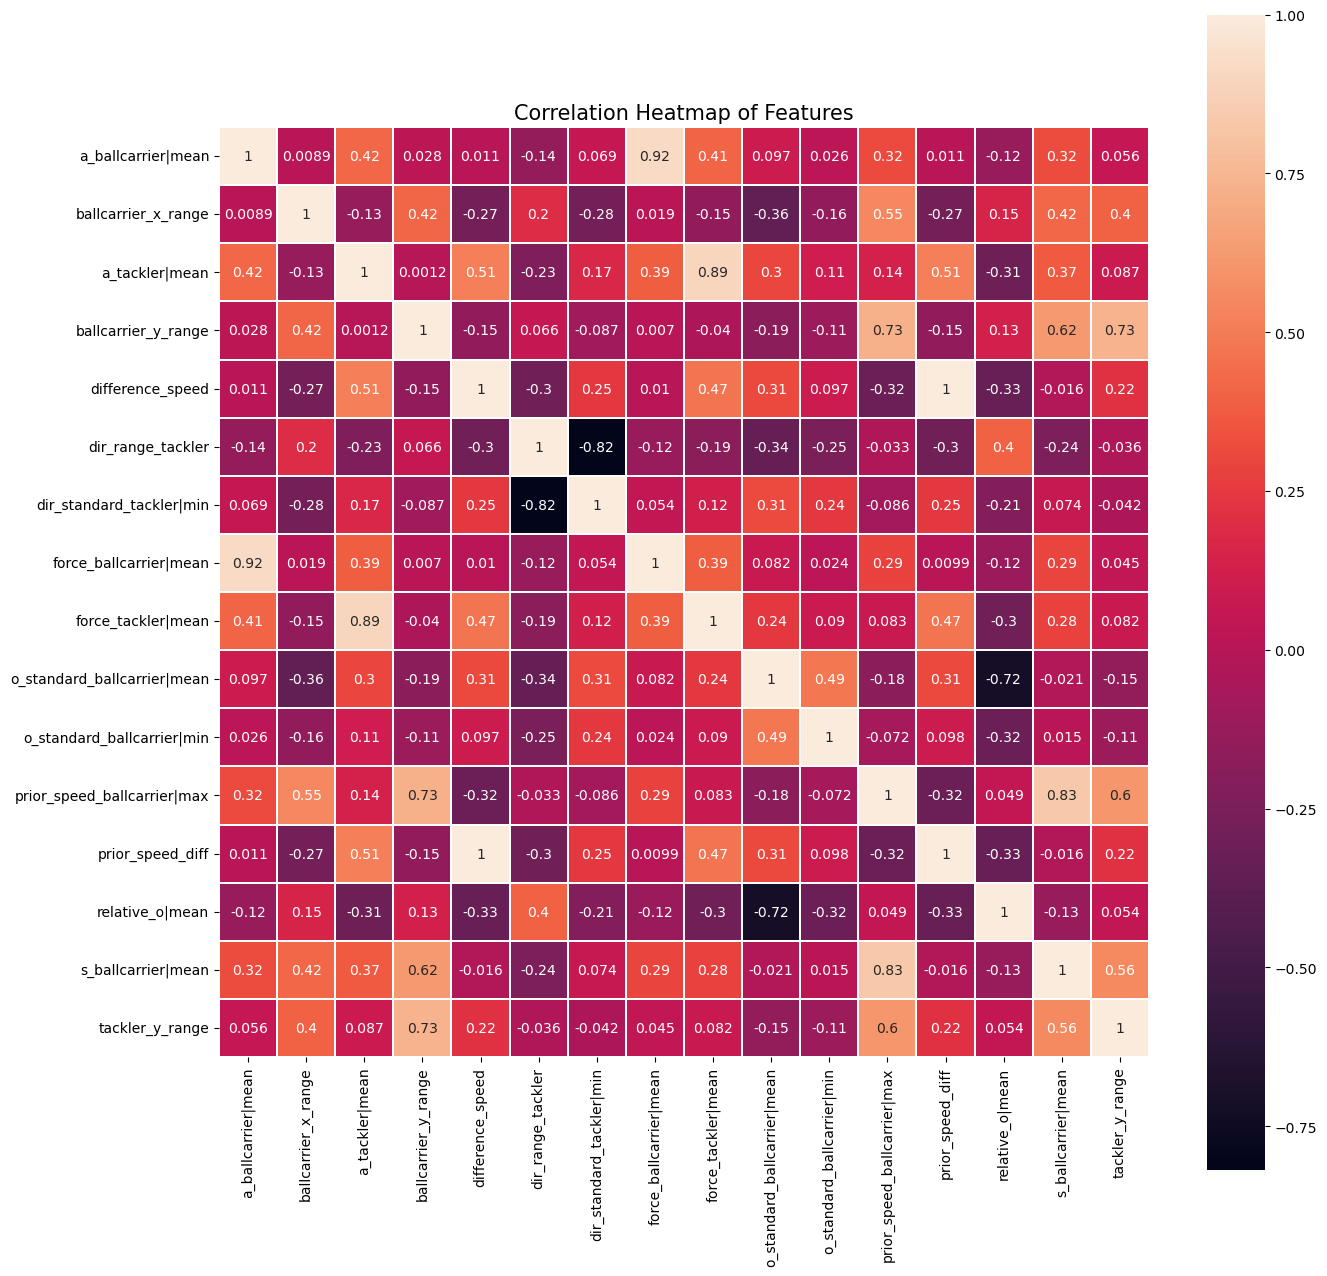

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,15))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(df_final_subset[final_cols].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

In [37]:
df_set=df_final[['displayName','nflId_tackler','tackle_event|max','missed_tackle|max','assist|max',
'a_ballcarrier|mean',
 'ballcarrier_x_range',
 'a_tackler|mean',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'force_ballcarrier|mean',
 'force_tackler|mean',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|mean',
 'tackler_y_range'

]].groupby(by=['displayName']).mean().reset_index()
df_set

df_set_gameplays=df_final[['displayName', 'gameplayid', 'nflId_tackler']].groupby(by=['displayName', 'nflId_tackler']).nunique().reset_index()
df_set_tackleassist=df_final[['displayName', 'tackle_event|max', 'missed_tackle|max', 'assist|max']].groupby(by='displayName').sum().reset_index()
df_set['gameplayid|nunique']=df_set_gameplays['gameplayid']
df_set[['tackle_count', 'missedTacklecount', 'assist_count']]=df_set_tackleassist[['tackle_event|max', 'missed_tackle|max', 'assist|max']]


In [38]:
df_final=df_final[(df_final['tackle_event|max']+ df_final['missed_tackle|max']==1)& (df_final['assist|max']==0)]
df_final.describe()

nflId_tackler  nflId_ballcarrier  tackle_event|max  assist|max  \
count    9854.000000        9854.000000       9854.000000      9854.0   
mean    47609.713213       48171.410493          0.801197         0.0   
std      4838.194855        4608.109842          0.399119         0.0   
min     33131.000000       25511.000000          0.000000         0.0   
25%     43986.000000       44874.000000          1.000000         0.0   
50%     46669.000000       47807.000000          1.000000         0.0   
75%     52542.000000       52733.000000          1.000000         0.0   
max     55241.000000       55158.000000          1.000000         0.0   

       missed_tackle|max  playNullifiedByPenalty|max  relative_o|mean  \
count        9854.000000                      9854.0      9854.000000   
mean            0.198803                         0.0        77.223447   
std             0.399119                         0.0        74.944856   
min             0.000000                         0.0      -318.053846   
25%             0.000000                         0.0        32.544855   
50%             0.000000                         0.0        88.381452   
75%             0.000000                         0.0       128.993174   
max             1.000000                         0.0       314.680625   

       relative_direction|mean  time_seconds|min  time_seconds|max  \
count              9854.000000       9854.000000       9854.000000   
mean                 70.728735       1700.330830       1709.092754   
std                  63.449131       1038.497816       1038.575155   
min                -183.395455          0.000000          0.000000   
25%                  26.301765        840.000000        840.000000   
50%                  61.417500       1680.000000       1680.000000   
75%                 108.779520       2640.000000       2640.000000   
max                 348.592500       3540.000000       3540.000000   

       x_tackler|min  x_tackler|max  x_tackler|mean  y_tackler|min  \
count    9854.000000    9854.000000     9854.000000    9854.000000   
mean       57.720861      63.312787       60.522762      22.605953   
std        23.468550      23.365818       23.278035      10.919407   
min         5.150000       9.320000        7.585000      -4.520000   
25%        39.190000      45.112500       42.285064      15.650000   
50%        58.270000      64.010000       61.006413      23.380000   
75%        76.010000      81.640000       78.878476      29.900000   
max       109.400000     115.980000      110.874231      51.930000   

       y_tackler|max  y_tackler|mean  s_tackler|first  s_tackler|last  \
count    9854.000000     9854.000000      9854.000000     9854.000000   
mean       31.364193       26.990699         2.310458        1.533166   
std        10.979372       10.660358         2.557252        1.319289   
min         1.820000       -0.068333         0.000000        0.000000   
25%        24.020000       19.967006         0.070000        0.560000   
50%        30.460000       26.904768         1.070000        1.100000   
75%        38.470000       34.156764         4.380000        2.120000   
max        57.790000       53.219286        10.520000        8.580000   

       s_tackler|min  s_tackler|max  s_tackler|mean  prior_speed_tackler|max  \
count    9854.000000    9854.000000     9854.000000              9854.000000   
mean        0.726535       5.385326        3.156946                 5.385067   
std         1.110764       1.784393        1.536975                 1.784741   
min         0.000000       0.350000        0.124000                 0.350000   
25%         0.030000       4.070000        1.997887                 4.070000   
50%         0.225000       5.340000        2.865604                 5.340000   
75%         0.920000       6.650000        3.983458                 6.650000   
max         8.580000      10.740000        9.449167                10.740000   

       next_speed_tackler|max  prior_speed_ballcar

LDA: 0.835803 (0.001673)
[LightGBM] [Info] Number of positive: 6316, number of negative: 1567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 7883, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801218 -> initscore=1.393923
[LightGBM] [Info] Start training from score 1.393923
[LightGBM] [Info] Number of positive: 6316, number of negative: 1567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 7883, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801218 -> inits

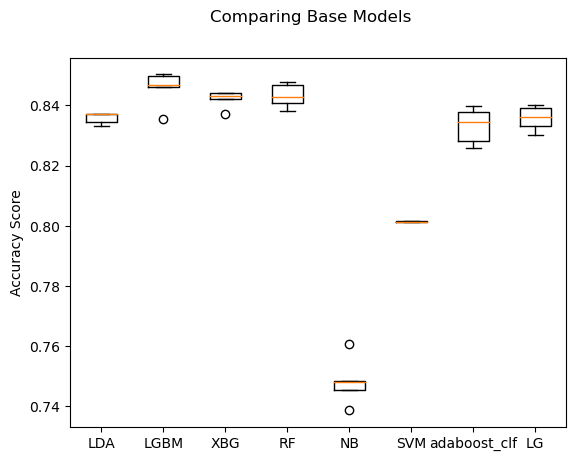

In [39]:
# Compare Algorithms
#!pip install xgboost
import pandas
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
X=df_final[final_cols
    
]

groups=df_final['displayName']
y=df_final['tackle_event|max']

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []

models.append(('LDA', LinearDiscriminantAnalysis()))
##models.append(('KNN', KNeighborsClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('XBG', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('adaboost_clf', AdaBoostClassifier(
    estimator=weak_learner,
    algorithm="SAMME",
    random_state=42,
)))
models.append(('LG', LogisticRegression()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=5)
    
    cv_results = model_selection.cross_val_score(model, X, y,  cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparing Base Models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy Score')
plt.show()


In [40]:
#!pip install optuna
import optuna  # pip install optuna
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y)

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "binary",
        "metric": "logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    }
    gbm = LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    prob = gbm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [41]:

study = optuna.create_study(study_name="lightgbm", direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)


[I 2023-12-21 16:20:33,454] A new study created in memory with name: lightgbm


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-21 16:20:33,592] Trial 0 finished with value: 0.8011363636363636 and parameters: {'lambda_l1': 3.225467939679e-05, 'lambda_l2': 0.0004805851295176965, 'num_leaves': 191, 'feature_fraction': 0.9303645881154822, 'bagging_fraction': 0.7460547323990101, 'bagging_freq': 7, 'min_child_samples': 62, 'learning_rate': 0.0037568023150682476}. Best is trial 0 with value: 0.8011363636363636.
[I 2023-12-21 16:20:33,666] Trial 1 finished with value: 0.8011363636363636 and parameters: {'lambda_l1': 3.1638010388706643, 'lambda_l2': 2.9961389131036094, 'num_leaves': 76, 'feature_fraction': 0.6735589390278318, 'bagging_fraction': 0.8599468441805131, 'bagging_freq': 4, 'min_child_samples': 81, 'learning_rate': 0.0007541258677670891}. Best is trial 0 with value: 0.8011363636363636.
[I 2023-12-21 16:20:33,870] Trial 2 finished with value: 0.8011363636363636 and parameters: {'lambda_l1': 9.794589135003394e-07, 'lambda_l2': 9.433944423012428e-07, 'num_leaves': 131, 'feature_fraction': 0.4119281004

In [42]:
print('Best parameters:', study.best_params)

Best parameters: {'lambda_l1': 0.8641220004331396, 'lambda_l2': 3.6628056604375016e-07, 'num_leaves': 110, 'feature_fraction': 0.8684914384809068, 'bagging_fraction': 0.881301931885194, 'bagging_freq': 1, 'min_child_samples': 45, 'learning_rate': 0.03384318920112793}


In [43]:
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y)

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    gbm =XGBClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    prob = gbm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(study_name="xgb", direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2023-12-21 16:20:38,833] A new study created in memory with name: xgb


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-12-21 16:20:38,889] Trial 0 finished with value: 0.8141233766233766 and parameters: {'max_depth': 2, 'learning_rate': 0.0255245487642803, 'n_estimators': 59, 'min_child_weight': 2, 'gamma': 5.877347593648463e-07, 'subsample': 0.18395853870560727, 'colsample_bytree': 0.8070033521739967, 'reg_alpha': 9.224412627086569e-05, 'reg_lambda': 0.5315603474209848}. Best is trial 0 with value: 0.8141233766233766.
[I 2023-12-21 16:20:39,027] Trial 1 finished with value: 0.8206168831168831 and parameters: {'max_depth': 4, 'learning_rate': 0.1794386956403231, 'n_estimators': 231, 'min_child_weight': 4, 'gamma': 0.0004859748152583614, 'subsample': 0.08105372997360741, 'colsample_bytree': 0.4851886151284906, 'reg_alpha': 0.0068383853106657256, 'reg_lambda': 3.812821254840957e-08}. Best is trial 1 with value: 0.8206168831168831.
[I 2023-12-21 16:20:39,153] Trial 2 finished with value: 0.823051948051948 and parameters: {'max_depth': 2, 'learning_rate': 0.47177454719385453, 'n_estimators': 296, '

In [44]:
print('Best parameters:', study.best_params)

Best parameters: {'max_depth': 7, 'learning_rate': 0.07987994417409205, 'n_estimators': 275, 'min_child_weight': 8, 'gamma': 1.901884868853062e-07, 'subsample': 0.9774930954563206, 'colsample_bytree': 0.49777149057957043, 'reg_alpha': 6.764449676486753e-06, 'reg_lambda': 0.016647653819453507}


In [45]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
    'n_estimators': trial.suggest_int("n_estimators", 10, 200, log=True),
    'max_depth' : trial.suggest_int("max_depth", 2, 32),
    'min_samples_split' : trial.suggest_int("min_samples_split", 2, 10),
    'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 10)
    }
    rf =RandomForestClassifier(**param)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    prob = rf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2023-12-21 16:20:43,681] A new study created in memory with name: rf


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-12-21 16:20:46,486] Trial 0 finished with value: 0.8376623376623377 and parameters: {'n_estimators': 124, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8376623376623377.
[I 2023-12-21 16:20:46,610] Trial 1 finished with value: 0.8206168831168831 and parameters: {'n_estimators': 13, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8376623376623377.
[I 2023-12-21 16:20:49,385] Trial 2 finished with value: 0.8356331168831169 and parameters: {'n_estimators': 130, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8376623376623377.
[I 2023-12-21 16:20:49,734] Trial 3 finished with value: 0.8356331168831169 and parameters: {'n_estimators': 16, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8376623376623377.
[I 2023-12-21 16:20:54,193] Trial 4 finished with value: 0.8380681818181818 and parameters: 

In [46]:
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 192, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 5}


In [47]:
lgbmparams= {'lambda_l1': 4.152388101674801, 'lambda_l2': 0.17474066980275066, 'num_leaves': 245, 'feature_fraction': 0.6192761230532181, 'bagging_fraction': 0.40583520811450247, 'bagging_freq': 4, 'min_child_samples': 44, 'learning_rate': 0.09037380952114289, 'class_weight':{0:2, 1:1}}
xgbparams=  {'max_depth': 6, 'learning_rate': 0.10321364517892449, 'n_estimators': 133, 'min_child_weight': 4, 'gamma': 3.7370606814124185e-07, 'subsample': 0.21039282194760126, 'colsample_bytree': 0.46503745302099037, 'reg_alpha': 0.00013987403882012288, 'reg_lambda': 8.588226259083729e-06}
rfparams= {'n_estimators': 197, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 3}

Accuracy: 0.8011161846778285
F1: 0.4447887323943662
Precision: 0.40055809233891426
Recall: 0.5
Kappa: 0.0
AUC:  0.5


Text(0.5, 1.0, 'Confusion Matrix')

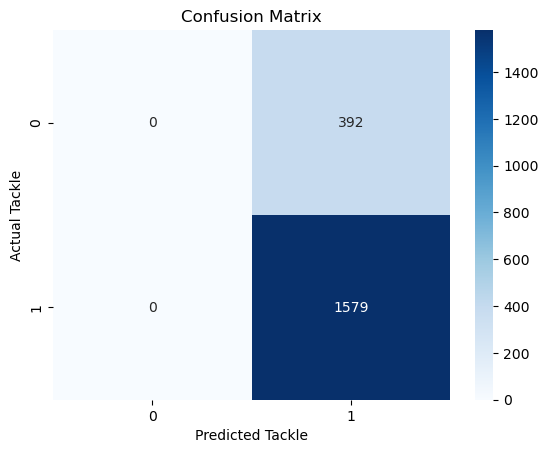

In [48]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score




dummy_clf = DummyClassifier(strategy="most_frequent")
X=df_final[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final['displayName']
y=df_final['tackle_event|max']

X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, test_size=0.2, random_state=1)

dummy_clf.fit(X_train, y_train)



y_pred =  dummy_clf.predict(X_test)
y_proba=dummy_clf.predict_proba(X_test)
matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("F1:", f1_score(y_test, y_pred,average='macro'))
print("Precision:", precision_score(y_test, y_pred,average='macro'))
print("Recall:", recall_score(y_test, y_pred,average='macro'))
print("Kappa:", cohen_kappa_score(y_test, y_pred))

print("AUC: ", roc_auc_score(y_test, y_pred))


sns.heatmap(matrix, annot=True,  cmap="Blues", fmt="g")
plt.xlabel('Predicted Tackle'); plt.ylabel('Actual Tackle'); plt.title('Confusion Matrix')

[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set=0.17474066980275066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17474066980275066
[LightGBM] [Warning] bagging_fraction is set=0.40583520811450247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40583520811450247
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set

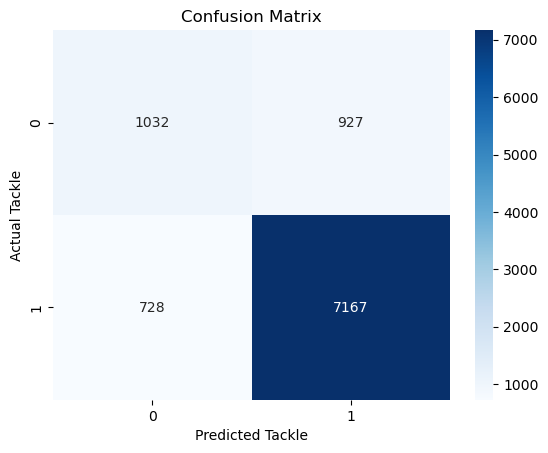

In [49]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from typing import Tuple
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

model =LGBMClassifier(**lgbmparams)
X=df_final[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final['displayName']
y=df_final['tackle_event|max']
kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array]:

    kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
    groups=df_final['displayName']
    
    
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X, y):

        X_train, y_train, X_test, y_test = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
       
        
        model.fit(
            X_train, y_train
        )


        


      
        actual_classes = np.append(actual_classes, y_test)
        

        predicted_classes = np.append(predicted_classes, model.predict(X_test))

        try:
            predicted_proba = np.append(predicted_proba, model.predict_proba(X_test), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(X_test), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    print("Accuracy:", accuracy_score(actual_classes, predicted_classes))

    print("F1:", f1_score(actual_classes, predicted_classes,average='macro'))
    print("Precision:", precision_score(actual_classes, predicted_classes,average='macro'))
    print("Recall:", recall_score(actual_classes, predicted_classes,average='macro'))
    print("Kappa:" , cohen_kappa_score(actual_classes, predicted_classes))
    print("AUC: ",  roc_auc_score(actual_classes, predicted_classes))
    plt.figure()
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted Tackle'); plt.ylabel('Actual Tackle'); plt.title('Confusion Matrix')

    plt.show()
    
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

Accuracy: 0.8386442053988228
F1: 0.7012925598991173
Precision: 0.7584663426618987
Recall: 0.6751629429265749
Kappa: 0.40885712588958023
AUC:  0.6751629429265749


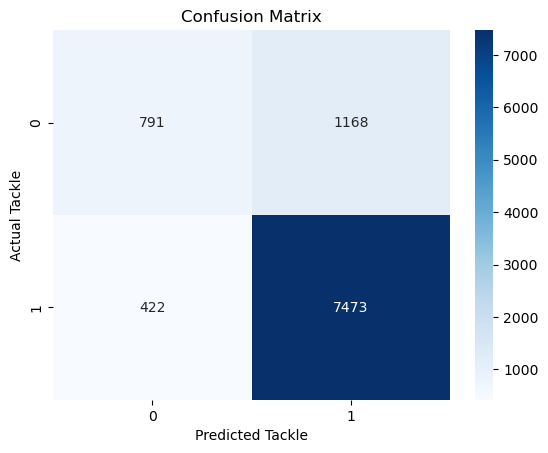

In [50]:
model=XGBClassifier(**xgbparams)
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

Accuracy: 0.8405723564034909
F1: 0.6731043951362375
Precision: 0.7906346565624298
Recall: 0.642591653274651
Kappa: 0.3629918700846322
AUC:  0.642591653274651


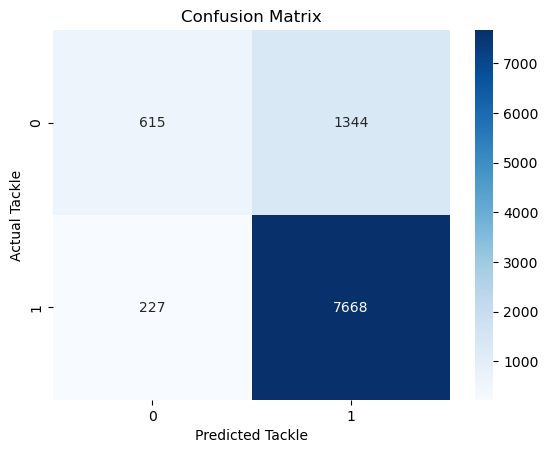

In [51]:
model=RandomForestClassifier(**rfparams)
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

In [52]:



df_train, df_test = train_test_split(df_final, stratify=df_final['tackle_event|max'], test_size=0.25, random_state=0)
import shap
# DF, based on which importance is checked
X_train=df_train[final_cols
    ]
df_test=df_test.reset_index()
X_test=df_test[final_cols]
y_train=df_train['tackle_event|max']
y_test=df_test['tackle_event|max']

model1=XGBClassifier(**xgbparams)
model1.fit(X_train, y_train)
probs1=model1.predict_proba(X_test)
model2=LGBMClassifier(**lgbmparams)
model2.fit(X_train, y_train)
probs2=model2.predict_proba(X_test)
model3=RandomForestClassifier(**rfparams)
model3.fit(X_train, y_train)
probs3=model3.predict_proba(X_test)






[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set=0.17474066980275066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17474066980275066
[LightGBM] [Warning] bagging_fraction is set=0.40583520811450247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40583520811450247
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set

In [75]:
import pickle
pickle.dump(model1, open('XGBoost.pkl','wb'))
pickle.dump(model2, open('LGBM.pkl','wb'))
pickle.dump(model3, open('RF.pkl','wb'))

In [54]:
df_test['prob_tackle1']=probs1[:, 1]
df_test['prob_miss1']=probs1[:, 0]

df_test['prob_tackle2']=probs2[:, 1]
df_test['prob_miss2']=probs2[:, 0]



df_test['prob_tackle3']=probs3[:, 1]
df_test['prob_miss3']=probs3[:, 0]


df_test['prob_tackle']=(df_test['prob_tackle1']+df_test['prob_tackle2']+df_test['prob_tackle3'])/3
df_test['prob_miss']=(df_test['prob_miss1']+df_test['prob_miss2']+df_test['prob_miss3'])/3

df_test['prediction']=np.where(df_test['prob_tackle']>.5, 1, 0)

df_test['y_test']=y_test

In [55]:
df_test[(df_test['prediction']!=df_test['y_test']) ]

index      gameplayid         displayName  nflId_tackler  \
2      8384   2022100902730        Greg Newsome          53455   
7      7397  20221002111265         Quay Walker          54487   
18     2400  20220918022064        Alim McNeill          53501   
25    12305  20221023041538         Tae Crowder          52663   
26     5664   2022092512620  De'Vondre Campbell          43404   
...     ...             ...                 ...            ...   
2429  16927  20221107002902         Marcus Maye          44851   
2446   6212   2022100201144        Mykal Walker          52527   
2450   6184   2022100200864         D.J. Wonnum          52525   
2454  12466  20221023052208     DeMarcus Walker          44863   
2458  15857   2022110602657        Keith Taylor          53595   

      nflId_ballcarrier  tackle_event|max  assist|max  missed_tackle|max  \
2                 45573                 1           0                  0   
7                 45185                 1           0                  0   
18                52474                 0           0                  1   
25                44835                 0           0                  1   
26                44816                 0           0                  1   
...                 ...               ...         ...                ...   
2429              43362                 1           0                  0   
2446              46104                 0           0                  1   
2450              37101                 1           0                  0   
2454              52449                 0           0                  1   
2458              44990                 1           0                  0   

      playNullifiedByPenalty|max  relative_o|mean  relative_direction|mean  \
2                              0        18.665089                 2.027679   
7                              0        23.643077                 1.833846   
18                             0       113.043462               110.018077   
25                             0        73.487925               121.759811   
26                             0        57.164667                92.776667   
...                          ...              ...                      ...   
2429                           0       107.713750               111.332045   
2446                           0       107.295904                33.250843   
2450                           0       116.688039                95.249608   
2454                           0       113.157458                 1.826610   
2458                           0       119.087667                39.919667   

                       time|min                   time|max  time_seconds|min  \
2    2022-10-09 13:30:11.000000 2022-10-09 13:30:22.099999            1800.0   
7    2022-10-02 17:26:38.900000 2022-10-02 17:26:46.599999            1560.0   
18   2022-09-18 14:45:01.099999 2022-09-18 14:45:06.200000            2700.0   
25   2022-10-23 14:08:35.500000 2022-10-23 14:08:40.700000             480.0   
26   2022-09-25 16:47:15.599999 2022-09-25 16:47:21.500000            2820.0   
...                         ...                        ...               ...   
2429 2022-11-07 22:29:02.200000 2022-11-07 22:29:10.900000            1740.0   
2446 2022-10-02 13:05:53.000000 2022-10-02 13:06:01.200000             300.0   
2450 2022-10-02 10:02:20.599999 2022-10-02 10:02:25.599999             120.0   
2454 2022-10-23 14:49:10.200000 2022-10-23 14:49:16.000000            2940.0   
2458 2022-11-06 13:30:13.299999 2022-11-06 13:30:19.200000            1800.0   

      time_seconds|max offenseFormation|first tacklerPosition|mode  \
2               1800.0             SINGLEBACK                   CB   
7               1560.0                SHOTGUN                  ILB   
18              2700.0                SHOTGUN                   NT   
25               480.0                SHOTGUN                  ILB   
26              2820.0                SHOTGUN       

Accuracy: 0.8563311688311688
F1: 0.7358720930232558
Precision: 0.7976997034774014
Recall: 0.7055145462440295
Kappa: 0.4768765743073048
AUC:  0.7055145462440295


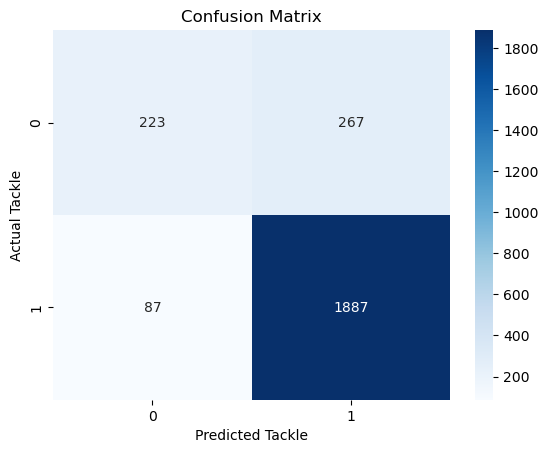

In [56]:
plot_confusion_matrix(df_test['y_test'], df_test['prediction'], [0,1])

In [57]:
X=df_set[final_cols]

model1 = pickle.load(open('XGBoost.pkl','rb'))
model2 = pickle.load(open('LGBM.pkl','rb'))
model1 = pickle.load(open('RF.pkl','rb'))

probs1=model1.predict_proba(X)
probs2=model2.predict_proba(X)
probs3=model3.predict_proba(X)

df_set['prob_tackle1']=probs1[:, 1]
df_set['prob_miss1']=probs1[:, 0]


df_set['prob_tackle2']=probs2[:, 1]
df_set['prob_miss2']=probs2[:, 0]



df_set['prob_tackle3']=probs3[:, 1]
df_set['prob_miss3']=probs3[:, 0]


df_set['ETSR']=(df_set['prob_tackle1']+df_set['prob_tackle2']+df_set['prob_tackle3'])/3




[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set=0.17474066980275066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17474066980275066
[LightGBM] [Warning] bagging_fraction is set=0.40583520811450247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40583520811450247
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [58]:
df_set['tackle_index']=round((df_set['ETSR']*((df_set['tackle_count']*1)+(df_set['assist_count']*.5)))-((1-df_set['ETSR'])*(df_set['missedTacklecount']+1)), 2)

In [59]:

df_tackler_merge=pd.merge(df_players[['nflId', 'position', 'displayName']], df_set[['displayName', 'tackle_index', 'ETSR']], on='displayName')
df_tackles_grouped=df_tackles[['nflId', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].groupby('nflId').sum() 
df_tackler_merge=pd.merge(df_tackler_merge, df_tackles_grouped, on='nflId')
df_tackler_merge.sort_values(by='tackle_index', ascending=False, inplace=True)
df_tackler_merge.reset_index(inplace=True)
df_tackler_merge[['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].sort_values(by='tackle_index', ascending=False).head(10)

displayName position  tackle_index      ETSR  tackle  assist  \
0  Foyesade Oluokun      ILB         55.81  0.858348      59      26   
1    Zaire Franklin      OLB         53.05  0.869067      55      28   
2      Roquan Smith      ILB         51.55  0.869340      50      32   
3       C.J. Mosley      ILB         50.91  0.843784      55      32   
4     Jordyn Brooks      ILB         49.92  0.866484      61      23   
5     Rashaan Evans      ILB         49.49  0.849538      45      39   
6     Bobby Okereke      ILB         48.13  0.892887      48      23   
7       Nick Bolton      ILB         47.30  0.906259      46      23   
8        David Long      ILB         43.08  0.860628      35      26   
9        David Long       CB         43.08  0.860628      10       3   

   forcedFumble  pff_missedTackle  
0             0                11  
1             0                12  
2             0                 7  
3             0                 8  
4             1                10  
5             1                 6  
6             1                 4  
7             0                 2  
8             0                 9  
9             0                 4

In [60]:
df_tackler_merge[['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].sort_values(by='ETSR', ascending=False).head(10)

displayName position  tackle_index      ETSR  tackle  assist  \
645    Brandin Echols       CB          1.49  0.994451       2       1   
676       Arron Mosby      OLB          0.99  0.994043       1       0   
678      Elijah Riley       CB          0.98  0.987661       1       0   
616      Ambry Thomas       CB          1.95  0.984113       3       0   
727      Percy Butler       FS          0.47  0.983209       0       1   
319  Jonathan Bullard       DE          9.30  0.980481       8       3   
681    Kristian Welch      ILB          0.96  0.979863       1       0   
730       Troy Reeder      ILB          0.46  0.974079       0       1   
590     Daviyon Nixon       DT          2.40  0.971513       1       3   
683    Andrew Wingard       FS          0.94  0.969859       1       0   

     forcedFumble  pff_missedTackle  
645             0                 0  
676             0                 0  
678             0                 0  
616             0                 0  
727             0                 0  
319             0                 0  
681             0                 0  
730             0                 0  
590             0                 0  
683             0                 0

<center><span style="font-size:36px;">  C.J. Mosley vs. Tony Adams</span> </center>

C.J.  Mosley is a top player from the NY Jets, but we wanted to look at his tackling stats compared to his teammate, Tony Adams. Mosley had **158 combined tackles and assists in 2022 and 131 in 2023**. Based on an analysis of his plays from 2022, his **ETSR is .73**, yet his tackle index is very high, putting him in the **top 10 players**.

On the other hand, Tony Adams has an **extremely high ETSR of .88 based on his 1 successful assist** that was recorded in our 2022 tracking data. His tackle index in 2022 was very low because he didn't play in many games, but based on the actions he took during that play, we expect his tackle success rate to be high, which is supported by his performance in 2023.



<br></br>
 <center><img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/h0j0fahb2xtffumugal3.png" alt="CJ Mosley" width="300"/></center>
 <center>C.J. Mosley</center> 

<br></br>

<center>

|SEASON |TEAM   |  TKL  |  AST  |  COMBINED |
| ----- | ----- |-------|-------|-----------|
|2023   |NY Jets|  72   |   59  |   131     |
|2022   |NY Jets|  99   |   59  |  158      |

</center>
 <br></br> 

In [61]:
df_tackler_merge[df_tackler_merge['displayName']=='C.J. Mosley'][['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']]

displayName position  tackle_index      ETSR  tackle  assist  forcedFumble  \
3  C.J. Mosley      ILB         50.91  0.843784      55      32             0   

   pff_missedTackle  
3                 8

 > ## "We have all these guys that play at an All-Pro level, and it makes you want to be better," Adams said. "I am just going out there and trying to be better because of those guys. And one day, I have hopes to play at that level too." 
  [NewYorkJets.com](https://www.newyorkjets.com/news/jets-tony-adams-buffalo-bills-josh-allen)

#### Maybe he can...


<br></br><center> <img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/jtsntdaohmgigyike1hq.png" alt="Tony Adams" width="300"/></center>
## <center>Tony Adams</center>  
<br></br>

<center>

|SEASON |TEAM   |  TKL  |  AST  |  COMBINED |
| ----- | ----- |-------|-------|-----------|
|2023   |NY Jets|  45   |   22  |   67      |
|2022   |NY Jets|  10   |   7   |  17       |

</center>


In [62]:
(df_tackler_merge[df_tackler_merge['displayName']=='Tony Adams'][['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']])

displayName position  tackle_index      ETSR  tackle  assist  \
747  Tony Adams       FS          0.34  0.891732       0       1   

     forcedFumble  pff_missedTackle  
747             0                 0


# Testing the ETSR and Tackle Index <a class="anchor"  id="5"></a>

 <center><b><i> A good test for the ETSR model would be to use his stats from his 2023 tracking data (or the second part of 2022) to determine if his tackle index increased and what happened to his ETSR. </i></b></center> 


For now, we decided to analyze two plays that the ETSR model "misclassified". We have one play the model predicted would be a tackle but was a miss, and another that the model predicted would be a miss but was a successful tackle. The two plays are analyzed below:


In [63]:
index_White=df_test[(df_test['gameplayid']=='20221023012468')].index.to_list()
index_Newsome=df_test[(df_test['gameplayid']=='2022100902730')].index.to_list()





The first play we're going to look at is one from Week 1 of the 2022 season. It was the Panthers vs. the Bucanneers. 
- [View Next Gen Animation](https://nextgenstats.nfl.com/highlights/play/type/team/2022/1/playerId/2022102301/2468)
<br></br>
Hubbard ran 17 yards for a touchdown and White missed the tackle. The model predicted this would be a successful tackle. The reason for this is that White's positioning was appropriate at the time of the tackle attempt and his acceleration was high enough to overcome Hubbard. However, we can see that he moved in the wrong direction when it came time to tackle. Most of the other conditions were suited for White to make the tackle, but he missed it. Therefore, the **ETSR is high but since White missed the tackle, this will count against him for his tackle index**.

In [74]:
import lime
from lime import lime_tabular
display(df_test.iloc[index_White])

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Miss', 'Tackle'],
    mode='classification'
)
exp = explainer.explain_instance(
    data_row=X_test.iloc[index_White[0]], 
    predict_fn=model1.predict_proba
)

exp.show_in_notebook(show_table=True)
exp = explainer.explain_instance(
    data_row=X_test.iloc[index_White[0]],  
    predict_fn=model2.predict_proba
)

exp.show_in_notebook(show_table=True)

exp = explainer.explain_instance(
    data_row=X_test.iloc[index_White[0]], 
    predict_fn=model3.predict_proba
)

exp.show_in_notebook(show_table=True)


index      gameplayid  displayName  nflId_tackler  nflId_ballcarrier  \
92  11978  20221023012468  Devin White          47788              53555   

    tackle_event|max  assist|max  missed_tackle|max  \
92                 0           0                  1   

    playNullifiedByPenalty|max  relative_o|mean  relative_direction|mean  \
92                           0       182.377963                37.712963   

                  time|min                time|max  time_seconds|min  \
92 2022-10-23 15:03:26.200 2022-10-23 15:03:31.500             180.0   

    time_seconds|max offenseFormation|first tacklerPosition|mode  \
92             180.0                SHOTGUN                  ILB   

   ballcarrierPosition|mode  x_tackler|min  x_tackler|max  x_tackler|mean  \
92                       RB          20.52          24.17       22.625556   

    y_tackler|min  y_tackler|max  y_tackler|mean  s_tackler|first  \
92          21.44          31.27       27.021296             0.01   

    s_tackler|last  s_tackler|min  s_tackler|max  s_tackler|mean  \
92            0.42            0.0           6.32        2.297778   

    prior_speed_tackler|max  next_speed_tackler|max  \
92                     6.32                    6.32   

    prior_speed_ballcarrier|max  next_speed_ballcarrier|max  a_tackler|min  \
92                         8.32                        8.32            0.0   

    a_tackler|max  a_tackler|mean  dis_tackler|min  dis_tackler|max  \
92           5.93        2.647963              0.0             0.63   

    dis_tackler|mean  o_standard_tackler|min  o_standard_tackler|max  \
92          0.227407                   45.39                  344.75   

    o_standard_tackler|mean  dir_standard_tackler|min  \
92               255.789259                      6.94   

    dir_standard_tackler|max  dir_standard_tackler|mean  \
92                    350.25                 124.838148   

    x_standard_tackler|min  x_standard_tackler|max  x_standard_tackler|mean  \
92                   95.83                   99.48                97.374444   

    y_standard_tackler|min  y_standard_tackler|max  y_standard_tackler|mean  \
92               22.063333               31.893333                26.312037   

    quarter|min  quarter|max  quarter|mean  down|min  down|max  down|mean  \
92            3            3           3.0         1         1        1.0   

    yardsToGo|min  yardsToGo|max  yardsToGo|mean gameClock|min gameClock|max  \
92             10             10            10.0          3:15          3:15   

    preSnapHomeScore|min  preSnapHomeScore|max  preSnapHomeScore|mean  \
92                     7                     7                    7.0   

    preSnapVisitorScore|min  preSnapVisitorScore|max  \
92                        0                        0   

    preSnapVisitorScore|mean  absoluteYardlineNumber|min  \
92                       0.0                          27   

    absoluteYardlineNumber|max  absoluteYardlineNumber|mean  \
92                          27                         27.0   

    defendersInTheBox|min  defendersInTheBox|max  defendersInTheBox|mean  \
92                    6.0                    6.0                     6.0   

    expectedPoints|min  expectedPoints|max  expectedPoints|mean  \
92            4.831687            4.831687             4.831687   

    tacklerWeight|mean  s_ballcarrier|first  s_ballcarrier|last  \
92               237.0                  0.0                7.29   

    s_ballcarrier|min  s_ballcarrier|max  s_ballcarrier|mean  \
92                0.0               8.32            5.447778   

    a_ballcarrier|min  a_ballcarrier|max  a_ballcarrier|mean  \
92                0.0               5.08            2.721481   

    dis_ballcarrier|min  dis_ballcarrier|max  dis_ballcarrier|mean  \
92                  0.0                 0.84              0.544074   

    o_standard_ballcarrier|min  o_standard_ballcarrier|max  \
92                       29.74                      102.71

[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set=0.17474066980275066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17474066980275066
[LightGBM] [Warning] bagging_fraction is set=0.40583520811450247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40583520811450247
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


The next play is an example of a a successful tackle that the model predicted would be a miss. 
- [View Next Gen Animation](https://nextgenstats.nfl.com/highlights/play/type/team/2022/1/playerId/2022100902/730)

<br></br>
In this play A.Ekeler had an amazing 71 yard run. In the end, Newsome tackled him before he made the touchdown, but not before he gained 71 yards for the Chargers. The model predicted this would bwe a failed tackle because Ekeler had already covered so much distance. In addition, Ekeler was going at top speed. In the end, Newsome caught up to him and was able to speed up enough to make the tackle, but the model treats this as a "poor" tackle due to the fact that so many yards were gained. The ETSR will go down for this play, but the tackle index will go up for making the tackle.

In [73]:
display(df_test.iloc[index_Newsome])
explainer2 = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Miss', 'Tackle'],
    mode='classification'
)
exp = explainer2.explain_instance(
    data_row=X_test.iloc[index_Newsome[0]], 
    predict_fn=model1.predict_proba
)

exp.show_in_notebook(show_table=True)
exp = explainer2.explain_instance(
    data_row=X_test.iloc[index_Newsome[0]],  
    predict_fn=model2.predict_proba
)

exp.show_in_notebook(show_table=True)

exp = explainer2.explain_instance(
    data_row=X_test.iloc[index_Newsome[0]], 
    predict_fn=model3.predict_proba
)

exp.show_in_notebook(show_table=True)

index     gameplayid   displayName  nflId_tackler  nflId_ballcarrier  \
2   8384  2022100902730  Greg Newsome          53455              45573   

   tackle_event|max  assist|max  missed_tackle|max  \
2                 1           0                  0   

   playNullifiedByPenalty|max  relative_o|mean  relative_direction|mean  \
2                           0        18.665089                 2.027679   

             time|min                   time|max  time_seconds|min  \
2 2022-10-09 13:30:11 2022-10-09 13:30:22.099999            1800.0   

   time_seconds|max offenseFormation|first tacklerPosition|mode  \
2            1800.0             SINGLEBACK                   CB   

  ballcarrierPosition|mode  x_tackler|min  x_tackler|max  x_tackler|mean  \
2                       RB          37.02         108.36       62.339107   

   y_tackler|min  y_tackler|max  y_tackler|mean  s_tackler|first  \
2            7.5          15.69       11.120089             0.37   

   s_tackler|last  s_tackler|min  s_tackler|max  s_tackler|mean  \
2            5.66           0.12          10.59        6.527232   

   prior_speed_tackler|max  next_speed_tackler|max  \
2                    10.59                   10.59   

   prior_speed_ballcarrier|max  next_speed_ballcarrier|max  a_tackler|min  \
2                        10.06                       10.06           0.08   

   a_tackler|max  a_tackler|mean  dis_tackler|min  dis_tackler|max  \
2           5.06        1.654196             0.01             1.07   

   dis_tackler|mean  o_standard_tackler|min  o_standard_tackler|max  \
2          0.653839                    1.27                  359.12   

   o_standard_tackler|mean  dir_standard_tackler|min  \
2               129.900893                       7.6   

   dir_standard_tackler|max  dir_standard_tackler|mean  \
2                    358.19                  94.401161   

   x_standard_tackler|min  x_standard_tackler|max  x_standard_tackler|mean  \
2                   37.02                  108.36                62.339107   

   y_standard_tackler|min  y_standard_tackler|max  y_standard_tackler|mean  \
2                     7.5                   15.69                11.120089   

   quarter|min  quarter|max  quarter|mean  down|min  down|max  down|mean  \
2            1            1           1.0         1         1        1.0   

   yardsToGo|min  yardsToGo|max  yardsToGo|mean gameClock|min gameClock|max  \
2             10             10            10.0          4:01          4:01   

   preSnapHomeScore|min  preSnapHomeScore|max  preSnapHomeScore|mean  \
2                    14                    14                   14.0   

   preSnapVisitorScore|min  preSnapVisitorScore|max  preSnapVisitorScore|mean  \
2                        0                        0                       0.0   

   absoluteYardlineNumber|min  absoluteYardlineNumber|max  \
2                          35                          35   

   absoluteYardlineNumber|mean  defendersInTheBox|min  defendersInTheBox|max  \
2                         35.0                    7.0                    7.0   

   defendersInTheBox|mean  expectedPoints|min  expectedPoints|max  \
2                     7.0            1.278587            1.278587   

   expectedPoints|mean  tacklerWeight|mean  s_ballcarrier|first  \
2             1.278587               188.0                  0.0   

   s_ballcarrier|last  s_ballcarrier|min  s_ballcarrier|max  \
2                5.46                0.0              10.06   

   s_ballcarrier|mean  a_ballcarrier|min  a_ballcarrier|max  \
2            7.495893                0.0               5.03   

   a_ballcarrier|mean  dis_ballcarrier|min  dis_ballcarrier|max  \
2            1.903214                  0.0                 1.03   

   dis_ballcarrier|mean  o_standard_ballcarrier|min  \
2              0.753661                        1.77   

   o_standard_ballcarrier|max  o_standard_ballcarrier|mean  \
2                      349.85                   111.235804 

[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set=0.17474066980275066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17474066980275066
[LightGBM] [Warning] bagging_fraction is set=0.40583520811450247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40583520811450247
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


# How is this useful and innovative? <a class="anchor"  id="6"></a>
We anticipate several use cases for our predictive model:
1. **Drafting new players** - based on tracking stats from prior tackle attempts, coaches and determine if a new player's ETSR makes them a good candidate for their team
2. **Adding to the PFF Player Grades** - We recommend adding a Tackle Grade in the PFF Player Grade cards. 
3. **Monitoring Player Progress** - If a player's ETSR starts to drop, it can mean that they are playing more inconsistently in terms of their tackling outcomes

# Data Dictionary
## Tackles data
- **gameId:** Game identifier, unique (numeric)
- **playId:** Play identifier, not unique across games (numeric)
- **nflId:** Player identification number, unique across players (numeric)
- **tackle:** Indicator for whether the given player made a tackle on the play (binary)
- **assist:** Indicator for whether the given player made an assist tackle on the play (binary)
- **forcedFumble:** Indicator for whether the given player forced a fumble on the play (binary)
- **pff_missedTackle:** Provided by Pro Football Focus (PFF). Indicator for whether the given player missed a tackle on the play (binary)

## Tracking data

- **gameId:** Game identifier, unique (numeric)
- **playId:** Play identifier, not unique across games (numeric)
- **nflId:** Player identification number, unique across players. When value is NA, row corresponds to ball. (numeric)
- **displayName:** Player name (text)
- **frameId:** Frame identifier for each play, starting at 1 (numeric)
- **time:** Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)
- **jerseyNumber:** Jersey number of player (numeric)
- **club:** Team abbrevation of corresponding player (text)
- **playDirection:** Direction that the offense is moving (left or right)
- **x:** Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)
- **y:** Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)
- **s:** Speed in yards/second (numeric)
- **a:** Speed in yards/second^2 (numeric)
- **dis:** Distance traveled from prior time point, in yards (numeric)
- **o:** Player orientation (deg), 0 - 360 degrees (numeric)
- **dir:** Angle of player motion (deg), 0 - 360 degrees (numeric)
- **event:** Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

# Resources Used


- https://francis-press.com/uploads/papers/ndkLZY5nQLH6nilaE0nfMi0dxkAogA90wpqUB2vK.pdf
- https://digitalcommons.unl.edu/cgi/viewcontent.cgi?article=1079&context=cbbbpapers
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9459770/
- https://www.frontiersin.org/articles/10.3389/fspor.2021.669845/full
- https://entertainment.howstuffworks.com/physics-of-football.htm
- I used this notebook to standardize all of my directional data: 
https://www.kaggle.com/code/colinlagator/make-all-plays-left-right 